In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
import seaborn as sns

from netam import framework, models
from netam.common import print_parameter_count

/Users/matsen/mambaforge/envs/epam/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_df, val_df = framework.load_shmoof_dataframes("/Users/matsen/data/shmoof_edges_11-Jan-2023_NoNode0_iqtree_K80+R_masked.csv", val_nickname="51")#, sample_count=5000)

In [3]:
kmer_length = 5
max_length = 500

train_dataset = framework.SHMoofDataset(train_df, kmer_length=kmer_length, max_length=max_length)
val_dataset = framework.SHMoofDataset(val_df, kmer_length=kmer_length, max_length=max_length)

print(f"we have {len(train_dataset)} training examples and {len(val_dataset)} validation examples")

we have 26592 training examples and 22424 validation examples


In [4]:
model = models.FivemerModel(kmer_length)
burrito = framework.SHMBurrito(train_dataset, val_dataset, model, batch_size=1024, learning_rate=0.1, l2_regularization_coeff=1e-7)
print_parameter_count(model)
print("starting training...")
losses = burrito.train(epochs=100)
burrito.save_crepe("../pretrained/fivemer")
losses.tail()

kmer_embedding: 1025 parameters
-----
total: 1025 parameters
starting training...


Epoch:  34%|███▍      | 34/100 [00:30<00:59,  1.11it/s, loss_diff=9.83e-08, lr=3.2e-5]   


,train_loss,val_loss
30,0.060774,0.061501
31,0.060776,0.061501
32,0.060775,0.061501
33,0.060777,0.061501
34,0.060776,0.061501


Training with regularization coefficient 0


Epoch:  76%|███████▌  | 38/50 [00:34<00:10,  1.10it/s, loss_diff=-3.246e-08, lr=3.2e-5] 


Training with regularization coefficient 1e-08


Epoch:  72%|███████▏  | 36/50 [00:32<00:12,  1.10it/s, loss_diff=-2.732e-08, lr=3.2e-5] 


Training with regularization coefficient 1e-07


Epoch:  70%|███████   | 35/50 [00:32<00:13,  1.09it/s, loss_diff=4.226e-08, lr=3.2e-5]  


Training with regularization coefficient 1e-06


Epoch:  64%|██████▍   | 32/50 [00:29<00:16,  1.09it/s, loss_diff=8.823e-08, lr=3.2e-5]  


Training with regularization coefficient 1e-05


Epoch:  66%|██████▌   | 33/50 [00:30<00:15,  1.08it/s, loss_diff=-1.521e-07, lr=3.2e-5] 


Training with regularization coefficient 0.0001


Epoch:  62%|██████▏   | 31/50 [00:28<00:17,  1.08it/s, loss_diff=-7.647e-08, lr=3.2e-5] 


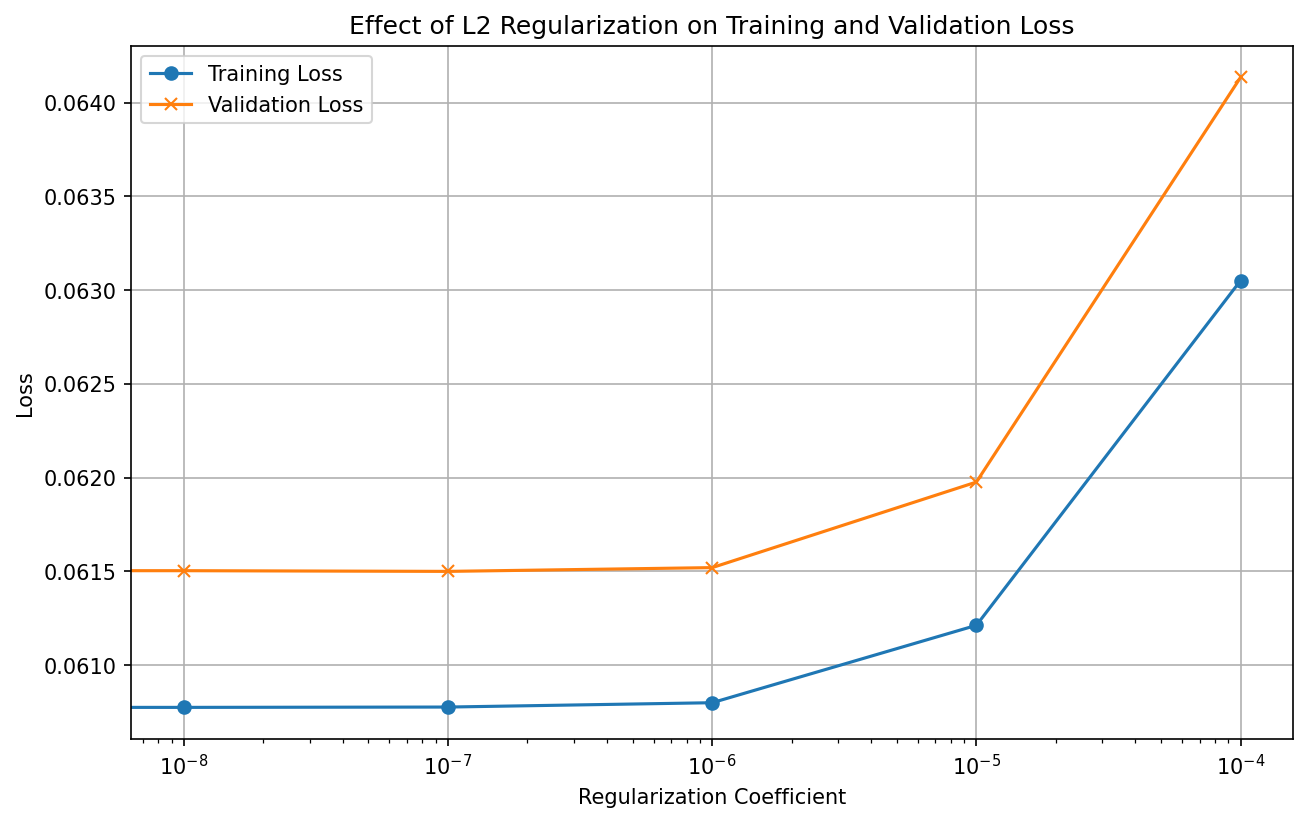

In [5]:
regularization_coeffs = [0, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]
results = []

for coeff in regularization_coeffs:
    print(f"Training with regularization coefficient {coeff}")
    model = models.FivemerModel(kmer_length)
    burrito = framework.SHMBurrito(train_dataset, val_dataset, model, batch_size=1024, learning_rate=0.1, l2_regularization_coeff=coeff)
    loss_history = burrito.train(epochs=50)
    final_training_loss = loss_history['train_loss'].iloc[-1]
    final_validation_loss = loss_history['val_loss'].iloc[-1]

    results.append({
        'Regularization': coeff,
        'Final_Training_Loss': final_training_loss,
        'Final_Validation_Loss': final_validation_loss
    })

regularization_results_df = pd.DataFrame(results)
plt.figure(figsize=(10, 6))
plt.plot(regularization_results_df['Regularization'], regularization_results_df['Final_Training_Loss'], label='Training Loss', marker='o')
plt.plot(regularization_results_df['Regularization'], regularization_results_df['Final_Validation_Loss'], label='Validation Loss', marker='x')

plt.xscale('log')
plt.xlabel('Regularization Coefficient')
plt.ylabel('Loss')
plt.title('Effect of L2 Regularization on Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
regularization_results_df

,Regularization,Final_Training_Loss,Final_Validation_Loss
0,0.000000e+00,0.060776,0.061504
1,1.000000e-08,0.060774,0.061503
2,1.000000e-07,0.060776,0.061499
3,1.000000e-06,0.060799,0.061519
4,1.000000e-05,0.061212,0.061976
5,1.000000e-04,0.063050,0.064134
